In [1]:
from spikingjelly.activation_based.monitor import OutputMonitor
from spikingjelly.activation_based.layer import SynapseFilter
from spikingjelly.activation_based.neuron import LIFNode
from spikingjelly.activation_based.functional import temporal_efficient_training_cross_entropy
from jaxtyping import Float, Int64
from torch import Tensor

import torch
import matplotlib.pyplot as plt
import wandb
import numpy as np
import spikingjelly.activation_based as snn
from spikingjelly.activation_based import surrogate, neuron, functional
from typing import Callable, Any, overload
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split

from utils.module import StochasticRound, SDCLinear, TransposeLayer
from utils.model import CCN
from utils.datasets import generate_lp_dataset, generate_cosine_dataset, generate_1d_dot_classification_dataset, encode_temporal

In [2]:
cfg = dict(
    NUM_SAMPLES = 10000,  # 총 10000 개의 샘플 생성
    VECTOR_DIM = 3,      # 각 벡터는 2차원
    MAX_VAL = 10.0,
    TIME_STEPS = 17,     # SNN을 23 타임스텝 동안 실행
    BATCH_SIZE = 32,
    NUM_CLASSES = 5
)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

np.random.seed(42)
rng = torch.manual_seed(42)

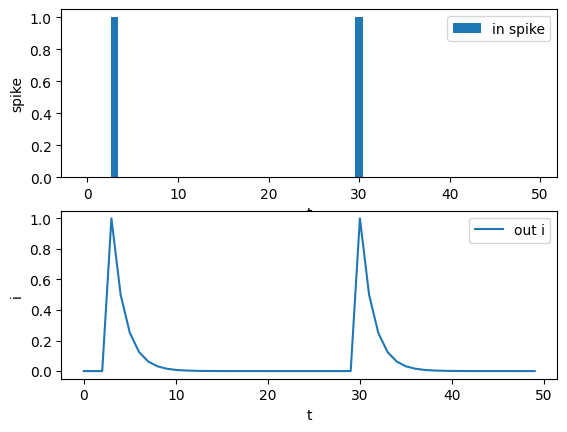

In [4]:
T = 50
in_spikes = (torch.rand(size=[T]) >= 0.95).float()
lp_syn = SynapseFilter(tau=1+1)
plt.subplot(2, 1, 1)
plt.bar(torch.arange(0, T).tolist(), in_spikes, label='in spike')
plt.xlabel('t')
plt.ylabel('spike')
plt.legend()

out_i = []
for i in range(T):
    out_i.append(lp_syn(in_spikes[i]))
plt.subplot(2, 1, 2)
plt.plot(out_i, label='out i')
plt.xlabel('t')
plt.ylabel('i')
plt.legend()
plt.show()

In [5]:
NUM_SAMPLES = cfg["NUM_SAMPLES"]  # 총 1000 개의 샘플 생성
VECTOR_DIM = cfg["VECTOR_DIM"]      # 각 벡터는 3차원
MAX_VAL = cfg["MAX_VAL"]
TIME_STEPS = cfg["TIME_STEPS"]     # SNN을 16 타임스텝 동안 실행
BATCH_SIZE = cfg["BATCH_SIZE"]
NUM_CLASSES = cfg["NUM_CLASSES"]

In [6]:
# x = torch.arange(0, TIME_STEPS, 1)
# y = x.flip(0)
# X = torch.stack([x, y], dim=-1)
# X = torch.nn.functional.one_hot(X, num_classes=TIME_STEPS)
# X = X.permute(-1, 0, 1)[:, None, ...]
# print(X.shape)
# for i in range(X.shape[-2]):
#     print(X[:,0,i,:])

In [7]:
# l = SDCLinear(TIME_STEPS, 2)
# print("X.shape:", X.shape)
# Y = l(X)
# print("Y.shape:", Y.shape)

In [8]:
torch.set_printoptions(threshold=10_000, precision=2, linewidth=160, sci_mode=False)

In [9]:
# for c in range(TIME_STEPS):
#     print(Y[:,0,c,:])

In [10]:
# model = torch.nn.Sequential(
#     SDCLinear(out_features=1).to(device),
#     LIFNode()
# )
# model

In [11]:
# X_data, y_data = generate_1d_dot_classification_dataset(NUM_SAMPLES, num_classes=NUM_CLASSES) # N 2, N 1
# X_data = torch.stack([torch.FloatTensor(encode_temporal(X_data[:,0], TIME_STEPS)),
#                       torch.FloatTensor(encode_temporal(X_data[:,1], TIME_STEPS))],
#                      dim=2) # T N 2
# y_data = torch.FloatTensor(y_data) / y_data.max() # N 1
# dataset = torch.utils.data.TensorDataset(X_data.transpose(1, 0), y_data)  # T N 2 -> N T 2

# train_set, test_set = train_test_split(dataset, test_size=0.2, random_state=42)

# train_loader = torch.utils.data.DataLoader(
#     train_set,
#     batch_size=BATCH_SIZE,
#     shuffle=True,
#     drop_last=False
#     )
# test_loader = torch.utils.data.DataLoader(
#     test_set,
#     batch_size=BATCH_SIZE,
#     shuffle=False,
#     drop_last=False
# )

# criterion = temporal_efficient_training_cross_entropy
# optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=0.)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=120 * (NUM_SAMPLES // BATCH_SIZE))
# loss = torch.tensor(float("inf"))

# pbar = tqdm(range(120))
# pred_hist, target_hist, err_hist = [], [], []
# # wandb_table = wandb.Table(columns=[f"v_{t}" for t in range(TIME_STEPS)], log_mode="INCREMENTAL")
# with wandb.init(project="DelayedTemporal",
#                 config=cfg) as run:
#     for epoch in pbar:
#         model.train()
#         for i, batch in enumerate(tqdm(train_loader, leave=False)):
#             inputs:Float[Tensor, "N T 2 D"]; targets:Float[Tensor, "N D"]
#             inputs, targets = batch
#             inputs = inputs.to(device); targets = targets.to(device)
#             # 모델 학습 코드 추가
#             inputs = inputs.transpose(1, 0) # N T 2 -> T N 2
#             inputs = inputs[:,:,None,:] # T N 2 -> T N 1 2
#             out = model(inputs) #  -> model -> N D
#             loss = criterion(out, targets.long()) #+ model.loss
            
#             optimizer.zero_grad()
#             loss.backward()
#             optimizer.step()
            
#             pbar.set_postfix({"loss": loss.item(), "scale":(out.max()-out.min()).item()})
#             if i % 10 == 0:
#                 # wandb_table.add_data(*v_seq.mean(dim=(1,2,3)).tolist())
#                 run.log({"loss": loss.item(),
#                         "err":(out - targets).abs().mean().item()}
#                         |
#                         {f"delay_{j}": model[0]._delay[j] for j in range(model[0]._delay.shape[0])})
#         scheduler.step()
        
#         with torch.no_grad():
#             model.eval()
#             for batch in tqdm(test_loader, leave=False):
#                 inputs, targets = batch
#                 inputs = inputs.to(device); targets = targets.to(device)
#                 # 모델 학습 코드 추가
#                 out = model(inputs.transpose(1, 0)) # NT(2D)->TN(2D)->model->N
                
#                 loss = criterion(out, targets)
#                 pred_hist.extend(out.squeeze().tolist())
#                 target_hist.extend(targets.squeeze().tolist())
#                 err_hist.extend((out.squeeze() - targets.squeeze()).abs().tolist())
#                 pbar.set_postfix({"loss": loss.item(), "pred": pred_hist[-1], "target": target_hist[-1]})

In [12]:
model = CCN(vector_dim = VECTOR_DIM, cc_acc=TIME_STEPS-1, feature_dims=[]).to(device)
model

CCN(
  (model): Sequential(
    (0): TransposeLayer()
    (1): SDCLinear(
      in_features=2, out_features=16
      (filter): SynapseFilter(tau=2.0, learnable=False, step_mode=m)
    )
    (2): LIFNode(
      v_threshold=1.0, v_reset=0.0, detach_reset=False, step_mode=m, backend=torch, tau=2.0
      (surrogate_function): ATan(alpha=2.0, spiking=True)
    )
    (3): SynapseFilter(tau=10.0, learnable=True, step_mode=m)
    (4): Linear(in_features=16, out_features=1, bias=True)
    (5): Flatten(start_dim=2, end_dim=-1)
    (6): LIFNode(
      v_threshold=1.0, v_reset=0.0, detach_reset=False, step_mode=m, backend=torch, tau=2.0
      (surrogate_function): ATan(alpha=2.0, spiking=True)
    )
  )
  (linear): Linear(in_features=3, out_features=1, bias=True)
  (out_neuron): NonSpikingIFNode()
)

In [13]:
X_data, y_data = generate_lp_dataset(NUM_SAMPLES, VECTOR_DIM, max_val=MAX_VAL)
X_data = torch.stack([torch.FloatTensor(encode_temporal(X_data[:,0,:], TIME_STEPS)),
                      torch.FloatTensor(encode_temporal(X_data[:,1,:], TIME_STEPS))],
                     dim=2) # T N 2D
y_data = torch.FloatTensor(y_data) / y_data.max() # N D
dataset = torch.utils.data.TensorDataset(X_data.transpose(1, 0), y_data)  # T N 2D -> N T 2D

train_set, test_set = train_test_split(dataset, test_size=0.2, random_state=42)

train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=False
    )
test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=BATCH_SIZE,
    shuffle=False,
    drop_last=False
)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=0.)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=120 * (NUM_SAMPLES // BATCH_SIZE))
loss = torch.tensor(float("inf"))

pbar = tqdm(range(120))
pred_hist, target_hist, err_hist = [], [], []
# wandb_table = wandb.Table(columns=[f"v_{t}" for t in range(TIME_STEPS)], log_mode="INCREMENTAL")
with wandb.init(project="DelayedTemporal",
                config=cfg) as run:
    for epoch in pbar:
        model.train()
        for i, batch in enumerate(tqdm(train_loader, leave=False)):
            inputs:Float[Tensor, "N T 2 D"]; targets:Float[Tensor, "N D"]
            inputs, targets = batch
            inputs = inputs.to(device); targets = targets.to(device)
            v_seq_pt = [] # list to save membrane potential sequences
            out = model(inputs.transpose(1, 0), v_seq_pt=v_seq_pt) # N T 2 D -> T N 2 D -> model -> N D
            loss = criterion(out, targets) #+ model.loss
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            v_seq = v_seq_pt[-1]
            pbar.set_postfix({"loss": loss.item(), "scale":(out.max()-out.min()).item()})
            if i % 10 == 0:
                # wandb_table.add_data(*v_seq.mean(dim=(1,2,3)).tolist())
                run.log({"loss": loss.item(),
                        "err":(out - targets).abs().mean().item()}
                        |
                        {f"delay_{j}": model.model[1]._delay[j] for j in range(model.model[1]._delay.shape[0])})
                for t in range(TIME_STEPS):
                    run.log({
                        f"model.2 rate_{i}": model.stats['model.2'][0][t,0,0,i] for i in range(v_seq.shape[-1])}
                            |
                            {
                        f"model.2 mem_{i}": v_seq[t,0,0,i] for i in range(v_seq.shape[-1])
                    })
        scheduler.step()
        
        with torch.no_grad():
            model.eval()
            for batch in tqdm(test_loader, leave=False):
                inputs, targets = batch
                inputs = inputs.to(device); targets = targets.to(device)
                out = model(inputs.transpose(1, 0)) # NT(2D)->TN(2D)->model->N
                
                loss = criterion(out, targets)
                pred_hist.extend(out.squeeze().tolist())
                target_hist.extend(targets.squeeze().tolist())
                err_hist.extend((out.squeeze() - targets.squeeze()).abs().tolist())
                pbar.set_postfix({"loss": loss.item(), "pred": pred_hist[-1], "target": target_hist[-1]})

  0%|          | 0/120 [00:00<?, ?it/s]

wandb: Currently logged in as: sizzflair97 to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

delay_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
delay_1,▁▂▃▃▃▃▃▃▃▃▃▃▃▃▃▄▄▅▅▅▇█████▇▇▇▇▇▇▆▆▆▆▆▆▆▆
delay_10,▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▆▇█████▇▇▇▇▆▆▆▆▆
delay_11,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▄▆▆▆▇▇▇███████▇▇▇▆▅
delay_12,▁▂▂▂▂▂▂▂▂▂▃▃▃▃▃▃▅▆▇▇███████████▇▇▇▇▇▆▆▆▆
delay_13,█▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇███▃▃▃▂▂▂▂▁▁▁▂▂▂▃▃▃▄
delay_14,▁▁▁▁▁▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▅▆▆▇▇███▇▇▇▇▇▆▆▆▆▆▆▇
delay_15,█▇▇█████████████▇▇▆▄▂▂▁▁▁▁▁▁▁▁▂▂▂▂▂▃▃▃▄▄
delay_2,▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇████▇▄▃▂▂▂▁▁▁▁▁▁▂▂▃▃▄▄
delay_3,▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▃▄▆▆▆▇████████▇▇▇▇▆▆▆
+40,...


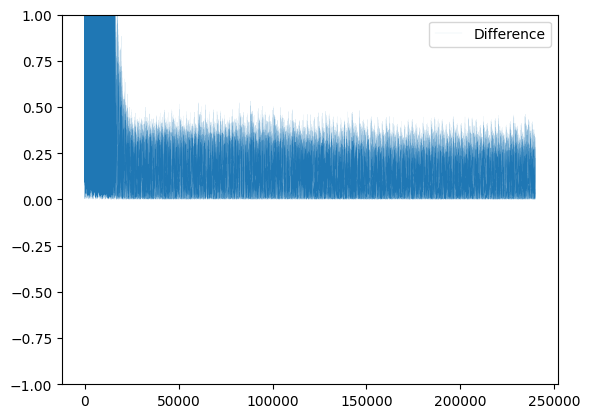

In [15]:
plt.plot(err_hist, linewidth=0.04, label="Difference")
plt.ylim(-1, 1)
plt.legend()

In [23]:
y_data

tensor([[0.68],
        [0.77],
        [0.50],
        [0.26],
        [0.17],
        [0.77],
        [0.16],
        [0.61],
        [0.54],
        [0.67],
        [0.20],
        [0.58],
        [0.65],
        [0.59],
        [0.47],
        [0.35],
        [0.57],
        [0.13],
        [0.68],
        [0.35],
        [0.66],
        [0.39],
        [0.25],
        [0.56],
        [0.27],
        [0.58],
        [0.38],
        [0.21],
        [0.31],
        [0.66],
        [0.42],
        [0.56],
        [0.54],
        [0.71],
        [0.06],
        [0.36],
        [0.36],
        [0.43],
        [0.34],
        [0.15],
        [0.74],
        [0.67],
        [0.59],
        [0.29],
        [0.39],
        [0.33],
        [0.30],
        [0.34],
        [0.32],
        [0.47],
        [0.51],
        [0.52],
        [0.74],
        [0.50],
        [0.38],
        [0.51],
        [0.53],
        [0.41],
        [0.40],
        [0.55],
        [0.23],
        [0.82],
        

In [22]:
for n in range(NUM_SAMPLES):
    print(abs(np.array(pred_hist)[-n] - np.array(target_hist)[-n]))

0.7216780185699463
0.03683018684387207
0.026938557624816895
0.06995698809623718
0.053095728158950806
0.13390761613845825
0.01762866973876953
0.08623141050338745
0.008733928203582764
0.22465220093727112
0.13306453824043274
0.0018658936023712158
0.09534525871276855
0.1181640475988388
0.04512965679168701
0.03339278697967529
0.02015233039855957
0.06701058149337769
0.14854401350021362
0.24873381853103638
0.1625027358531952
0.1477624475955963
0.04077741503715515
0.06694284081459045
0.01996093988418579
0.029652774333953857
0.05918124318122864
0.09696939587593079
0.06403756141662598
0.12963742017745972
0.10134243965148926
0.06292754411697388
0.010455548763275146
0.05246007442474365
0.04987013339996338
0.02223341166973114
0.13203053176403046
0.07669243216514587
0.0843467116355896
0.06853225827217102
0.005061626434326172
0.021778345108032227
0.0329153835773468
0.013211101293563843
0.12401682138442993
0.03686365485191345
0.05230960249900818
0.07875815033912659
0.05783364176750183
0.07080647349357

KeyboardInterrupt: 